In [1]:
from IPython.display import Markdown, display
import pandas as pd
import cv2
from matplotlib import pyplot as plt 
from tqdm.notebook import tqdm_notebook as tqdm

import data_preparation as dp
import src.config as config
from src.utility import plot_value_counts
from src.dataset_loader import get_train_valid

from sklearn.model_selection import train_test_split

CELEBA_DIR = 'CelebA_Spoof/'

# Spoof атаки, которые оставляем
spoof_filter = [0, 1, 2, 3, 7, 8, 9]

## Data Preparation

Train / Test shape
          original: (494405, 44) / (67170, 44)
          filtered: (356690, 44) / (49646, 44)


#### Train set Spoof labels

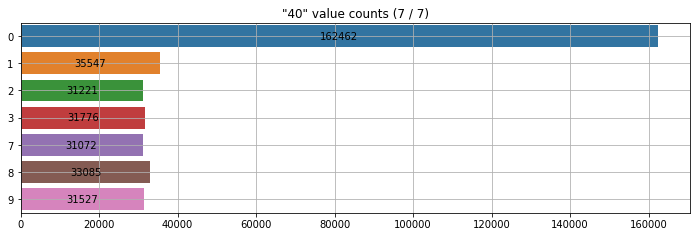

#### Test set Spoof labels

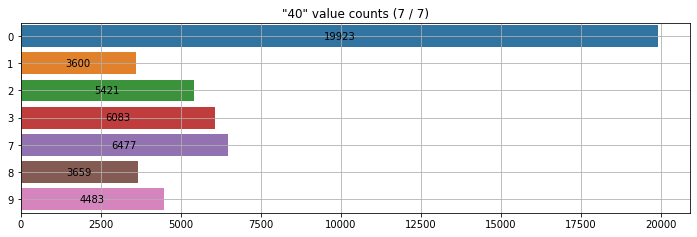

In [2]:
train_label, test_label = dp.read_orig_labels(CELEBA_DIR, spoof_filter)

display(Markdown('#### Train set Spoof labels'))
plot_value_counts(train_label[40], sort_index=True)
display(Markdown('#### Test set Spoof labels'))
plot_value_counts(test_label[40], sort_index=True)

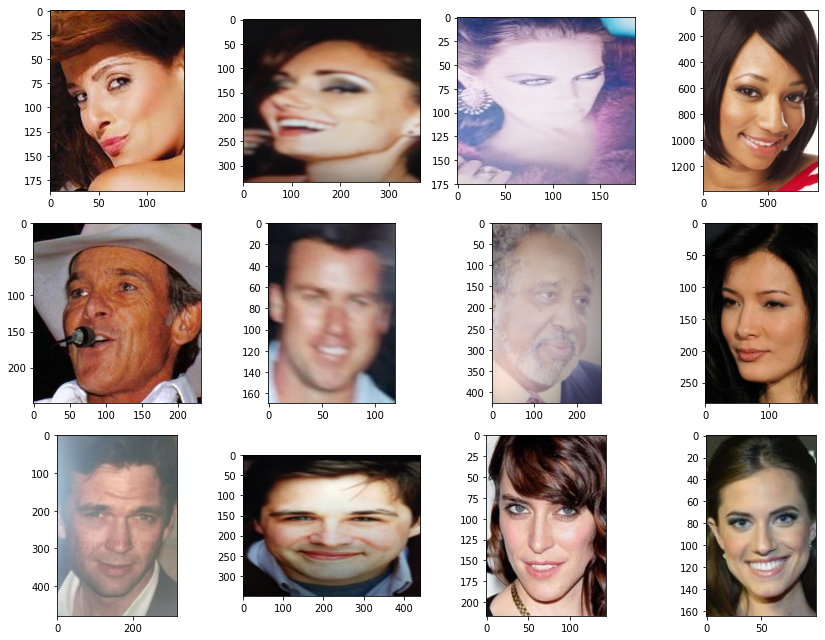

In [3]:
fig = plt.figure(figsize=(12,9))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    img = dp.read_image('/'.join([CELEBA_DIR, train_label.index[i]]))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
plt.show()

In [4]:
del train_label, test_label

## Сlass balance

#### Binary classification: Live / Spoof

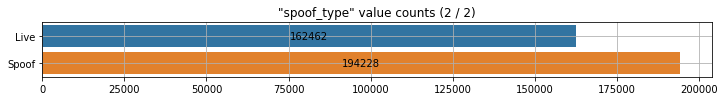

#### Live / Print attack / Replay attack

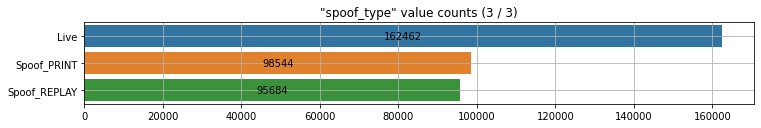

In [5]:
cnf = config.get_train_config()

train_labels = pd.read_csv(cnf.labels_path)

def live_spoof(v):
    return 'Live' if v == 0 else 'Spoof'

def live_print_replay(v):
    if v in [1,2,3]:
        return 'Spoof_PRINT'
    if v in [7,8,9]:
        return 'Spoof_REPLAY'
    if v == 0:
        return 'Live'
    return 'other'

display(Markdown('#### Binary classification: Live / Spoof'))
spoofs = train_labels['spoof_type'].apply(lambda s: live_spoof(s))
plot_value_counts(spoofs ,sort_index=True)

display(Markdown('#### Live / Print attack / Replay attack'))
spoofs = train_labels['spoof_type'].apply(lambda s: live_print_replay(s))
plot_value_counts(spoofs, sort_index=True)

## Testing data loader

In [15]:
cat = [[0],[1,2,3],[7,8,9]]
train_labels = pd.read_csv(cnf.labels_path)
spoof_transform = lambda t: next(i for i, l in enumerate(cat) if t in l)
train_labels.iloc[:,1] = train_labels.iloc[:,1].apply(spoof_transform)
value_counts = train_labels.iloc[:,1].value_counts()
train_downsampled = [train_labels[train_labels.iloc[:,1]==value_counts.index[-1]]]
for value in value_counts.index[:-1]:
    train_downsampled.append(
        train_labels[train_labels.iloc[:,1]==value].sample(
            value_counts.min()))
train_labels = pd.concat(train_downsampled)
train_labels.iloc[:,1].value_counts()

2    95684
0    95684
1    95684
Name: spoof_type, dtype: int64

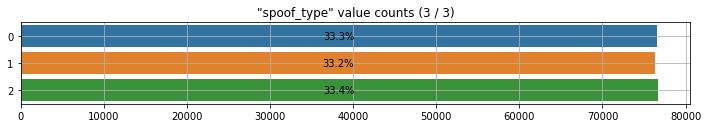

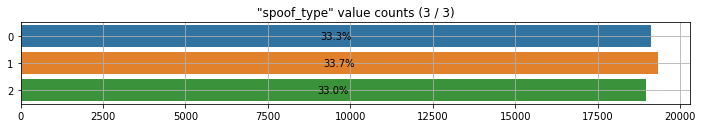

In [16]:
train_labels, valid_labels = train_test_split(train_labels, 
                                              test_size=cnf.valid_size, 
                                              random_state=20220826)

train_spoofs = train_labels['spoof_type']
plot_value_counts(train_spoofs ,sort_index=True, show_percents=True)
valid_spoofs = valid_labels['spoof_type']
plot_value_counts(valid_spoofs ,sort_index=True, show_percents=True)

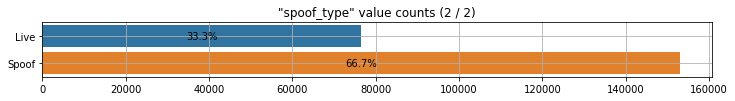

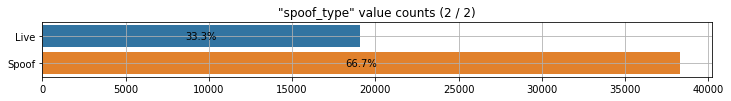

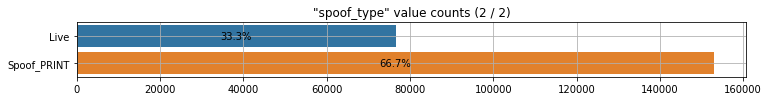

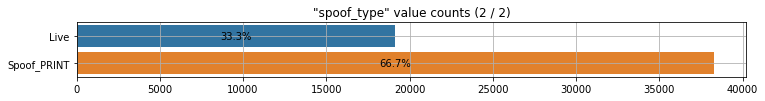

In [14]:
#train_labels = pd.read_csv(cnf.labels_path)
train_labels, valid_labels = train_test_split(train_labels, 
                                              test_size=cnf.valid_size, 
                                              random_state=20220826)

train_spoofs = train_labels['spoof_type'].apply(lambda s: live_spoof(s))
plot_value_counts(train_spoofs ,sort_index=True, show_percents=True)
valid_spoofs = valid_labels['spoof_type'].apply(lambda s: live_spoof(s))
plot_value_counts(valid_spoofs ,sort_index=True, show_percents=True)

train_spoofs = train_labels['spoof_type'].apply(lambda s: live_print_replay(s))
plot_value_counts(train_spoofs ,sort_index=True, show_percents=True)
valid_spoofs = valid_labels['spoof_type'].apply(lambda s: live_print_replay(s))
plot_value_counts(valid_spoofs ,sort_index=True, show_percents=True)

0    129913
1    129913
Name: spoof_type, dtype: int64


### Training loader batch

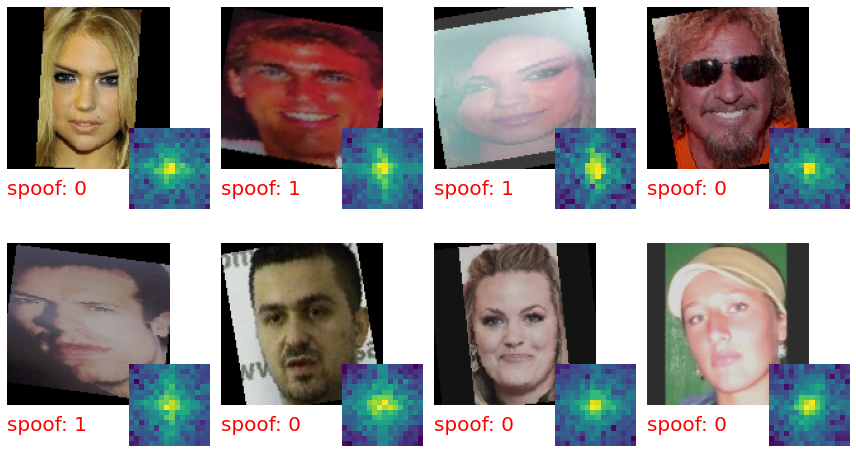

### Valitation loader batch

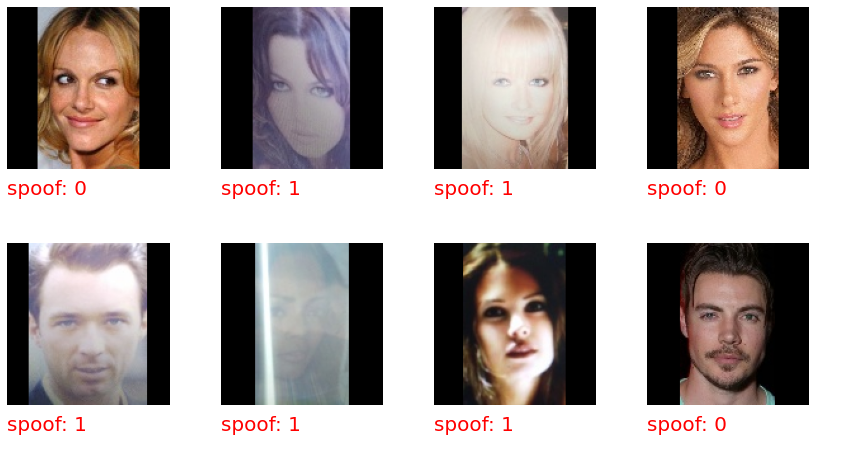

In [10]:
import torchvision.transforms as T

def plot_iter_images(iter, size, rows):
    if len(iter) > 2:
        display(Markdown('### Training loader batch'))
        sample, ft_sample, target = iter
    else:
        display(Markdown('### Valitation loader batch'))
        sample, target = iter
        ft_sample = None
    target = target.numpy()
    fig = plt.figure(figsize=(12,4*rows))
    for i in range(cnf.batch_size):
        ax = fig.add_subplot(rows, 4, i+1)
        ax.axis('off')
        
        plt.imshow(T.ToPILImage()(sample[i]), extent=(0,size,0,size))
        plt.text(0, -20, 'spoof: {}'.format(target[i]), 
                 fontsize = 20, color='red')
        if ft_sample is not None:
            plt.imshow(T.ToPILImage()(ft_sample[i]), 
                       extent=(3*size/4,5*size/4,-size/4,size/4))
        plt.xlim(0, 5*size/4)
        plt.ylim(-size/4, size)
        plt.yticks([])
        plt.xticks([])
        plt.tight_layout()
    plt.show()

cnf = config.get_train_config(
    spoof_categories='binary', class_balancing='down')
cnf.batch_size = 8
train_loader, valid_loader = get_train_valid(cnf)

plot_iter_images(iter(train_loader).next(), 
                 cnf.input_size, cnf.batch_size // 4)
plot_iter_images(iter(valid_loader).next(), 
                 cnf.input_size, cnf.batch_size // 4)

2    76578
0    76578
1    76578
Name: spoof_type, dtype: int64


### Training loader batch

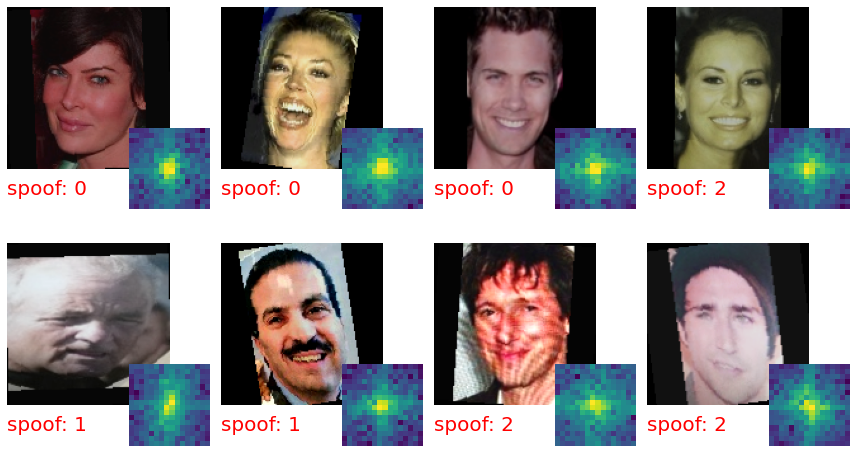

### Valitation loader batch

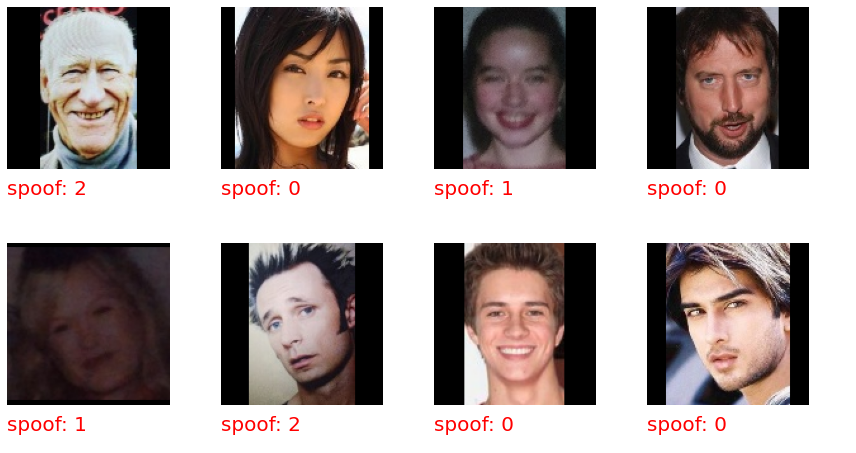

In [12]:
cnf = config.get_train_config(
    spoof_categories=[[0],[1,2,3],[7,8,9]],
    class_balancing='down')
cnf.batch_size = 8
train_loader, valid_loader = get_train_valid(cnf)

plot_iter_images(iter(train_loader).next(), 
                 cnf.input_size, cnf.batch_size // 4)
plot_iter_images(iter(valid_loader).next(), 
                 cnf.input_size, cnf.batch_size // 4)